# Challenge: Airline Arrivals

Use this [dataset](http://stat-computing.org/dataexpo/2009/the-data.html) of airline arrival information to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

The data comes originally from RITA.

It consists of the following variables:

1.	Year	1987-2008
2.	Month	1-12
3.	DayofMonth	1-31
4.	DayOfWeek	1 (Monday) - 7 (Sunday)
5.	DepTime	actual departure time (local, hhmm)
6.	CRSDepTime	scheduled departure time (local, hhmm)
7.	ArrTime	actual arrival time (local, hhmm)
8.	CRSArrTime	scheduled arrival time (local, hhmm)
9.	UniqueCarrier	unique carrier code
10.	FlightNum	flight number
11.	TailNum	plane tail number
12.	ActualElapsedTime	in minutes
13.	CRSElapsedTime	in minutes
14.	AirTime	in minutes
15.	ArrDelay	arrival delay, in minutes
16.	DepDelay	departure delay, in minutes
17.	Origin	origin IATA airport code
18.	Dest	destination IATA airport code
19.	Distance	in miles
20.	TaxiIn	taxi in time, in minutes
21.	TaxiOut	taxi out time in minutes
22.	Cancelled	was the flight cancelled?
23.	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24.	Diverted	1 = yes, 0 = no
25.	CarrierDelay	in minutes
26.	WeatherDelay	in minutes
27.	NASDelay	in minutes
28.	SecurityDelay	in minutes
29.	LateAircraftDelay	in minutes

## Exploring the data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
airlines_full = pd.read_csv('C:\\Users\\User\\Documents\\Python_scripts\\Thinkful\\airline_arrivals.csv')
airlines_full.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [3]:
airlines_full.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               136246
CRSDepTime                 0
ArrTime               151649
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
Origin                     0
Dest                       0
Distance                   0
TaxiIn                151649
TaxiOut               137058
Cancelled                  0
CancellationCode     6872294
Diverted                   0
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

The database has some missing values. The most missing values are for the type of delay (CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, and LateAircraftDelay) - but only if there is a delay - and CancellationCode (which only has values if a flight was cancelled).

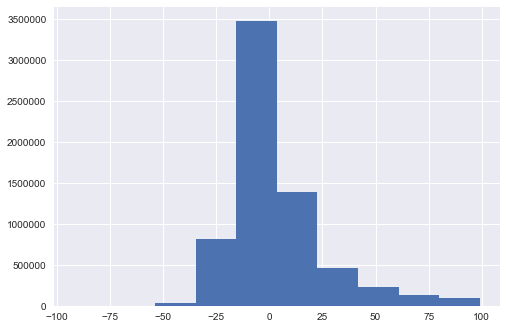

In [36]:
# Histogram - note the cut-off of extreme values on both sides
plt.hist(airlines_full.loc[(abs(airlines_full['ArrDelay'])<100), 'ArrDelay'].dropna())
plt.show()

Note the bulk of flights actually land a couple of minutes early!

- Mean for full sample: 8.16
- Median for full sample: -2.0

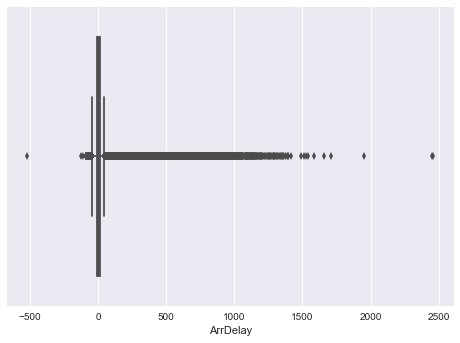

In [32]:
# Boxplot to look at outliers
sns.boxplot(airlines_full['ArrDelay'])
plt.show()

### Describing the model

Outcome variable: ArrDelay (measured in minutes)
- Negative values (for early arrivals): Keep negative values for regression. 
- Cancelled flights (indefinitely late): Since cancelled flights have no arrival time, there is no arrival delay (137,434 of the 154,699 missing values in ArrDelay is due to cancelled flights). For now these are excluded, but it could be explicitly included if a binary classification (late, not late) is used.
- Outliers: Remove large negative outliers. Keep positive outliers
- Scaling: Use robust scalar (standardized scalar is influenced by positive outliers)
- Unbalanced sample: Of the 7,009,728 flights in the dataset, only 901,398 (13%) were late. However, here I try to predict ArrDelay - a continuous variable - therefore therefore the effect is smaller (than say, using a binary late | not late) 

Considerations for features:
- Year is 2008 for all observations and is therefore not used. In future combining datasets from multiple years is likely to improve the model.
- Use of DepDelay (delay of departure in minutes): This is likely to be strongly correlated with ArrDelay since airplanes have a limited ability to catch-up time in flight (see scatter below). Using DepDelay will result in a very high R2, but doesn't add much predictive understanding and is therefore excluded.
- All time variables are kept (month, week, day) and time of day is converted to minutes from hhmm
- Arrival times are not included as it is too strongly correlated with departure time
- Unique carrier code is included (delays may be airline specific). There are 20 unique airlines in the dataset.
- Flightnumber can capture specific route issues. Flightnumber is listed as an integer, but it is a categorical variable (the number itself has no meaning beyond an identifier). There are 7,539 unique flight codes, creating dummy variables will therefore expand the feature set too much. One option is to only the top, say, 500 flight codes (representing 20% of all late flights - see figure below). The intercept will therefore capture all the other flight codes. Another possibility is to exclude flight number at all and let the origin airport, destiation airport, and unique carrier features capture most of this variance (flight numbers are linked to origin and destination and unique carrier captures the airline). The only loss would be if there a route with multiple stops which shares the same code. Here, the first attempt will be to exclude all Flightnumbers
- TailNum can show specific aeroplane issues (e.g. old vs new) which could impact delays. However, this not seem to be the case (see figure below). Furthermore, TailNum is also categorical and there are about 5,000 airplanes. To keep the model as simple as possible TailNum is not included.
- Airtime (in minutes): Longer flights may have more delays. Strongly correlated with Distance and therefore not included.
- Origin and Destination IATA codes: Particular airports may be more prone to delays. Also categorical. Only the top 50 origin and destination airports are included (see figures below)
- Distance (in miles): Given that only the top 50 origin and destination airports are included the distance feature is also included
- Taxi in and out times may influence ArrDelay, but are likely to be unknown when forecasting and is therefore excluded from the model. Some of this data is likely to be captured through specific airport characteristics (e.g. long taxi times due to limited bays)
- Cancelled flights: See above
- Diverted flights will almost always be late (included as binary)
- CarrierDelay/ WeatherDelay / NASDelay / SecurityDelay / LateAircraftDelay (all in minutes): These variables will all have a strong correlation with ArrDelay (as they break ArrDelay into subsets which sum to ArrDelay). However, 5,484,993 of the observations are missing. Observations are only expected when a plane is late, but accounting for this there are 1,454,769 observations missing. Including these observations will result in a very high R2, but similar to DepDelay it will not be known beforehand and therefore does not add much predictive power. It is therefore excluded from the model.

The outcome variable is continuous and the feature set will still be large (greater than 100). The OLS assumptions are unlikely to hold, so non-linear and non-parametric techniques are preferred.

Here I'll try 3:
- Random forest
- SVM
- Gradient boosting

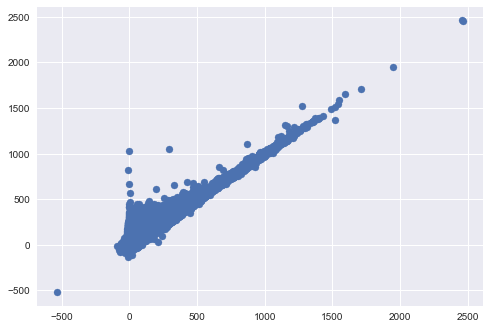

In [47]:
# DepDelay and ArrDelay are pretty much the same thing
plt.scatter(airlines_full['DepDelay'], airlines_full['ArrDelay'])
plt.show()

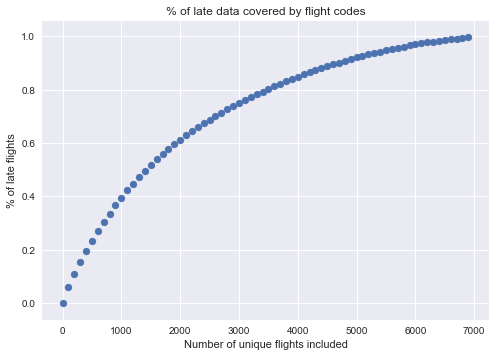

In [120]:
# Looking for a trade-off between number of flight codes (eventually the dummy variables) 
# and number of late flights covered 

# Count flight codes for all late flights (sorted descending)
flightnums = airlines_full.loc[airlines_full['ArrDelay']>30, 'FlightNum'].value_counts()

lateflights = []

numberofflightcodes = []

# Calculate coverage of late flights by top i flight codes
for i in range(0, 7000,100):
    lateflights.append(flightnums[0:i].sum()/flightnums.sum())
    numberofflightcodes.append(i)

plt.scatter(y=lateflights, x=numberofflightcodes)
plt.title('% of late data covered by flight codes')
plt.ylabel('% of late flights')
plt.xlabel('Number of unique flights included')
plt.show()

    

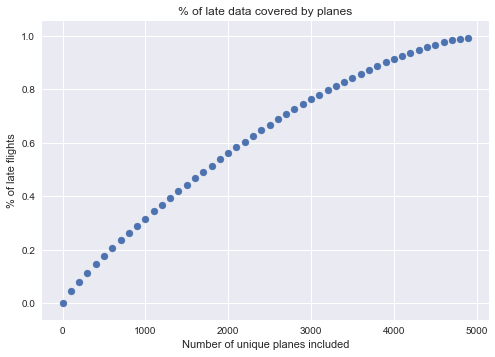

In [122]:
# Trade-off between TailNums and late flights

# Count flight codes for all late flights (sorted descending)
tailnums = airlines_full.loc[airlines_full['ArrDelay']>30, 'TailNum'].value_counts()

lateplane = []

numberoffplanes = []

# Calculate coverage of late flights by top i flight codes
for i in range(0, 5000,100):
    lateplane.append(tailnums[0:i].sum()/tailnums.sum())
    numberoffplanes.append(i)

plt.scatter(y=lateplane, x=numberoffplanes)
plt.title('% of late data covered by planes')
plt.ylabel('% of late flights')
plt.xlabel('Number of unique planes included')
plt.show()

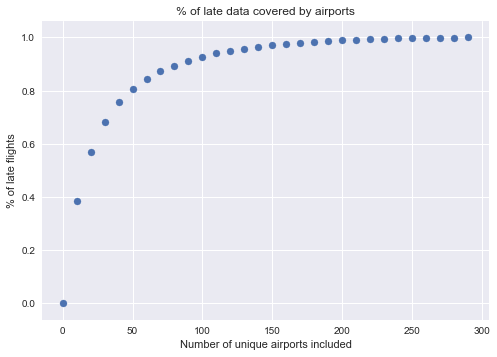

In [125]:
# Trade-off between origin airport and late flights

# Count airports for all late flights (sorted descending)
origin = airlines_full.loc[airlines_full['ArrDelay']>30, 'Origin'].value_counts()

lateplane = []

numberofairports = []

# Calculate coverage of late flights by top i flight codes
for i in range(0, 300,10):
    lateplane.append(origin[0:i].sum()/origin.sum())
    numberofairports.append(i)

plt.scatter(y=lateplane, x=numberofairports)
plt.title('% of late data covered by airports')
plt.ylabel('% of late flights')
plt.xlabel('Number of unique airports included')
plt.show()

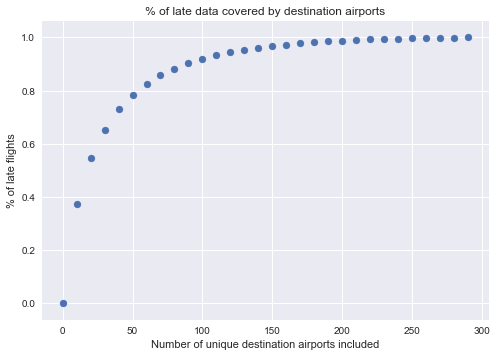

In [126]:
# Trade-off between destination airport and late flights

# Count airports for all late flights (sorted descending)
destination = airlines_full.loc[airlines_full['ArrDelay']>30, 'Dest'].value_counts()

lateplane = []

numberofairports = []

# Calculate coverage of late flights by top i flight codes
for i in range(0, 300,10):
    lateplane.append(destination[0:i].sum()/destination.sum())
    numberofairports.append(i)

plt.scatter(y=lateplane, x=numberofairports)
plt.title('% of late data covered by destination airports')
plt.ylabel('% of late flights')
plt.xlabel('Number of unique destination airports included')
plt.show()

## Making a smaller database

Unfortunately the size of the database is too big to run some of the models on my local. I there have to make the database smaller, even after dropping NaN of ArrDelay (mainly due to cancelled flights which don't have an ArrDelay observation) . Below I randomly select 500,000 samples (no replacement).

In [3]:
# Reduce sample to 20,000 to speed up calculation (avoid MemoryError)
airlines = airlines_full.sample(20000, replace=False)

In [4]:
# Dropping the negative outliers in ArrDelay (60 minutes or earlier), 343 dropped + ALL NaN
airlines = airlines.loc[airlines_full['ArrDelay']>-60,:]

# Dropping all flights later than a day (1440 minutes)
airlines = airlines.loc[airlines_full['ArrDelay']<1440,:]



## Getting the data ready for modeling

In [22]:
from sklearn import preprocessing

# Set departure time to minutes
timestring = airlines.CRSDepTime.astype('str')
# Change hhmm to string to split to hh and mm, and then convert to minutes
hours = timestring.apply(lambda x: x[:2]).astype('int')
minutes = timestring.apply(lambda x: x[-2:]).astype('int')
airlines['DepartureTime'] = hours*60+minutes
airlines.DepartureTime.value_counts()

# Drop columns which aren't used int the model
airlines.drop(['Year', 'DayofMonth', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime','FlightNum', 'TailNum',
               'ActualElapsedTime', 'CRSElapsedTime','AirTime', 'DepDelay', 'TaxiIn',
               'TaxiOut', 'Cancelled', 'CancellationCode', 'CarrierDelay',
               'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
               inplace=True, axis=1)

# Set dtype to categorical
for col in ['Month', 'DayOfWeek','UniqueCarrier', 'Origin', 'Dest']:
    airlines[col] = airlines[col].astype('category')
    
# Copy into a df to use pd.get_dummies
fordummies = airlines.loc[:, ['Month', 'DayOfWeek','UniqueCarrier', 'Origin', 'Dest']]
    
# Get top 10 origin and late dummies (based on most late flights)
# Top 50 is a better cut-off point, but it adds too much complexity
latecount = airlines.loc[airlines['ArrDelay']>30, 'Origin'].value_counts()
originpd = list(latecount.index.astype('str')[0:51])
latecountD = airlines.loc[airlines['ArrDelay']>30, 'Dest'].value_counts()
destpd = list(latecountD.index.astype('str')[0:51])

# Get top 5 airlines
#airlinecount = airlines.loc[airlines['ArrDelay']>30, 'UniqueCarrier'].value_counts()
#topairlines = list(latecount.index.astype('str')[0:16])

# Top 50 origin and destination airports
fordummies['Origin_new'] = fordummies.Origin.where(fordummies.Origin.isin(originpd), 'other')
fordummies['Dest_new'] = fordummies.Dest.where(fordummies.Dest.isin(destpd), 'other')
#fordummies['Airline_new'] = fordummies.UniqueCarrier.where(fordummies.UniqueCarrier.isin(topairlines), 'other')


# Drop old Origin and Dest
fordummies.drop(['Origin', 'Dest'], axis=1, inplace=True)

# Make some dummies
dummies = pd.get_dummies(fordummies)

# Join dummies to airlines and drop original categories (and ArrDelay)
airlines.drop(['Month', 'DayOfWeek',
               'UniqueCarrier', 'Origin', 'Dest'], inplace=True, axis=1)

X = pd.concat([airlines, dummies], axis=1)

In [23]:
for col in X.columns:
    print(col)

ArrDelay
Distance
Diverted
DepartureTime
Month_1
Month_2
Month_3
Month_4
Month_5
Month_6
Month_7
Month_8
Month_9
Month_10
Month_11
Month_12
DayOfWeek_1
DayOfWeek_2
DayOfWeek_3
DayOfWeek_4
DayOfWeek_5
DayOfWeek_6
DayOfWeek_7
UniqueCarrier_9E
UniqueCarrier_AA
UniqueCarrier_AQ
UniqueCarrier_AS
UniqueCarrier_B6
UniqueCarrier_CO
UniqueCarrier_DL
UniqueCarrier_EV
UniqueCarrier_F9
UniqueCarrier_FL
UniqueCarrier_HA
UniqueCarrier_MQ
UniqueCarrier_NW
UniqueCarrier_OH
UniqueCarrier_OO
UniqueCarrier_UA
UniqueCarrier_US
UniqueCarrier_WN
UniqueCarrier_XE
UniqueCarrier_YV
Origin_new_ATL
Origin_new_AUS
Origin_new_BDL
Origin_new_BNA
Origin_new_BOS
Origin_new_BUR
Origin_new_BWI
Origin_new_CLE
Origin_new_CLT
Origin_new_CVG
Origin_new_DAL
Origin_new_DCA
Origin_new_DEN
Origin_new_DFW
Origin_new_DTW
Origin_new_EWR
Origin_new_FLL
Origin_new_HNL
Origin_new_HOU
Origin_new_IAD
Origin_new_IAH
Origin_new_IND
Origin_new_JFK
Origin_new_LAS
Origin_new_LAX
Origin_new_LGA
Origin_new_MCI
Origin_new_MCO
Origin_new_MDW
O

In [39]:
corrs = X.corr()
print(corrs)

                  ArrDelay  Distance  Diverted  DepartureTime   Month_1  \
ArrDelay          1.000000  0.008240       NaN      -0.087226  0.010431   
Distance          0.008240  1.000000       NaN       0.021218 -0.007356   
Diverted               NaN       NaN       NaN            NaN       NaN   
DepartureTime    -0.087226  0.021218       NaN       1.000000 -0.004352   
Month_1           0.010431 -0.007356       NaN      -0.004352  1.000000   
Month_2           0.039381 -0.014398       NaN      -0.008464 -0.089127   
Month_3           0.030310  0.004885       NaN       0.006697 -0.094256   
Month_4          -0.014760 -0.009972       NaN       0.005572 -0.094135   
Month_5          -0.023927  0.003175       NaN      -0.000265 -0.096411   
Month_6           0.049744  0.015717       NaN      -0.000693 -0.091546   
Month_7           0.020524  0.008963       NaN       0.005739 -0.095127   
Month_8          -0.015976  0.012893       NaN      -0.002027 -0.093196   
Month_9          -0.05512

In [23]:
# Check and drop NaN in X
X.dropna(inplace=True)

# Scaling X (standard scalar)
X_scaled = X.copy()
print(X_scaled.Distance.mean())
print(X_scaled.ArrDelay.mean())
X_scaled.loc[:,['Distance', 'ArrDelay', 'DepartureTime']]=preprocessing.scale(X.loc[:, ['Distance', 'ArrDelay', 'DepartureTime']])
print(X_scaled.Distance.mean())
print(X_scaled.ArrDelay.mean())
# Set y and drop from X
y_scaled = X_scaled['ArrDelay']
X_scaled.drop(['ArrDelay'], axis=1, inplace=True)

# Set y and drop from X
y = X['ArrDelay']
X.drop(['ArrDelay'], axis=1, inplace=True)


727.0543960810328
8.18089503495433
1.6208338385735434e-17
-9.163397703024295e-18


In [24]:
from sklearn import model_selection

# Unscaled split X and y
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y)

# Scaled split X and y
Xs_train, Xs_test, ys_train, ys_test = model_selection.train_test_split(X_scaled,y_scaled)


## Random Forest Regressor

In [26]:
from sklearn import ensemble

# No need for scaled data in random forest - using X, y.

# Create instance
rf = ensemble.RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

# Test model
y_hat = rf.predict(X_test)
scored = rf.score(X_test, y_test)
print(scored)

#plt.scatter(x=y_test, y=y_hat)
#plt.show()


-0.0175279743385


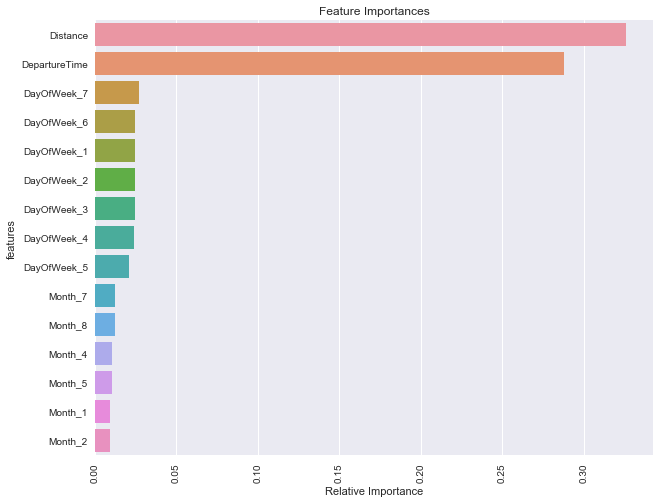

In [12]:
features = list(X.columns)
importances = rf.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(y = feature_imp.features[0:15], x = feature_imp.importance[0:15], orient="h")
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

In [13]:
# Cross Validation

rfc = ensemble.RandomForestRegressor()
cv = model_selection.cross_val_score(rfc, X, y, cv=5)
print(cv)

[-0.13230988 -0.11486508 -0.08751163 -0.14108643 -0.11148358]


In [35]:
rfc_small = ensemble.RandomForestClassifier()
rfc_small.fit(X_train.loc[:, ['Distance', 'DepartureTime']], y_train)
score_small = rfc_small.score(X_test.loc[:, ['Distance', 'DepartureTime']], y_test)
print(score_small)

0.0218367346939


## SVM

In [27]:
from sklearn import svm

# Creating SVC instance
svr = svm.SVR()
svr.fit(Xs_train, ys_train)
params = svr.get_params()

# Checking fit
scored = svr.score(Xs_test, ys_test)
y_hat = svr.predict(Xs_test)
print(scored)
#plt.scatter(ys_test, y_hat)
#plt.show()

-0.0226394021618


In [ ]:
#CV
svr = svm.SVCR()
cv = model_selection.cross_val_score(svr, X_scaled,y_scaled, cv=5)
print(cv)

## OLS

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x000001B7DEF6A828>>


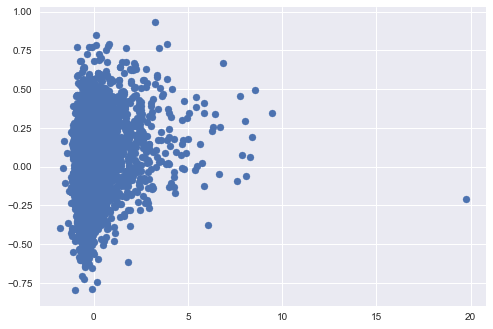

In [28]:
import statsmodels.api as sm
Xs_train['constant'] = 1
Xs_test['constant'] = 1

ols = sm.OLS(ys_train, Xs_train)
result = ols.fit()
print(result.summary)

y_hat = result.predict(Xs_test)
errors = ys_test - y_hat

plt.scatter(ys_test, y_hat)
plt.show()



In [29]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     5.806
Date:                Thu, 15 Mar 2018   Prob (F-statistic):           4.18e-92
Time:                        08:16:04   Log-Likelihood:                -20598.
No. Observations:               14697   AIC:                         4.148e+04
Df Residuals:                   14556   BIC:                         4.255e+04
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Distance             0.0024      0.010  

[]

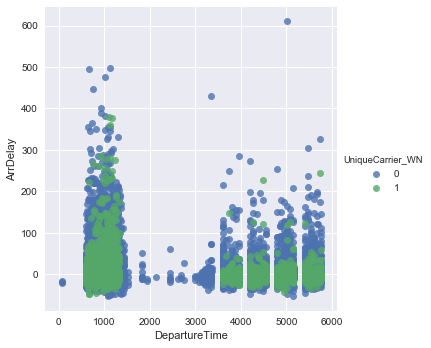

In [24]:
sns.lmplot('DepartureTime', 'ArrDelay', data=X, hue = 'UniqueCarrier_WN', fit_reg=False)
plt.plot()

In [26]:
X['Late'] = X.ArrDelay.apply(lambda x: 1 if x>30 else 0)

In [28]:
X.groupby('Late').mean()

,ArrDelay,Distance,Diverted,DepartureTime,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_new_SAT,Dest_new_SEA,Dest_new_SFO,Dest_new_SJC,Dest_new_SJU,Dest_new_SLC,Dest_new_SMF,Dest_new_STL,Dest_new_TPA,Dest_new_other
Late,,,,,,,,,,,,,,,,,,,,,
0,-2.828285,726.804606,0.0,2061.09377,0.086271,0.076115,0.085917,0.084972,0.086802,0.080661,...,0.006436,0.016593,0.018069,0.008444,0.003425,0.021317,0.007440,0.009035,0.011869,0.234426
1,81.804869,789.532071,0.0,1589.86476,0.097759,0.109351,0.096986,0.070711,0.078053,0.117079,...,0.006955,0.011592,0.031298,0.006182,0.005410,0.010433,0.007728,0.010819,0.011978,0.209428


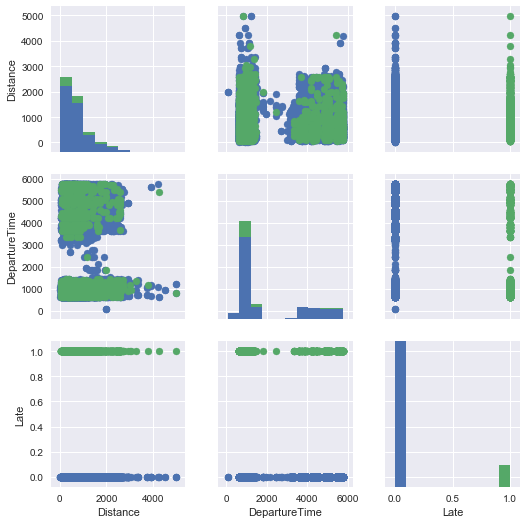

In [48]:
g = sns.PairGrid(X.loc[:, ['Distance', 'DepartureTime', 'Late']].dropna(), hue = 'Late')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
plt.show()

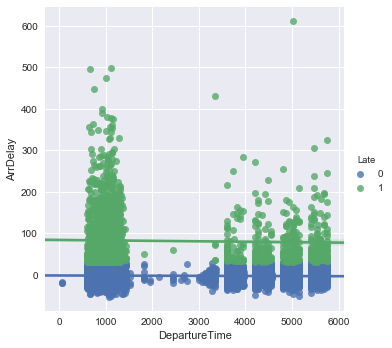

In [50]:
sns.lmplot(y = 'ArrDelay', x= 'DepartureTime', hue='Late', data=X)
plt.show()

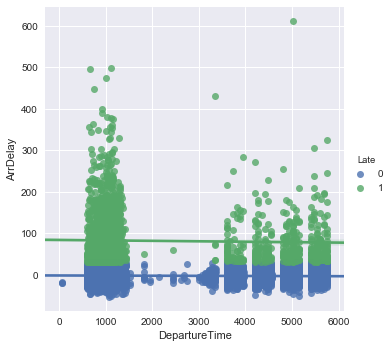

In [51]:
sns.lmplot(y = 'ArrDelay', x= 'DepartureTime', hue='Late', data=X)
plt.show()

## Conclusion

The models presented here did a poor job in explaining or predicting late flight arrivals. However, this finding is still interesting as there is no evidence that any airport or airline is systematically late (contrary to popular belief!).

The model can possibly be improved by using a dummy independent variable, although the graphs above still suggest it is likely to have poor predictive power.

Finally, the model can be improved if parameters such as taxi-time, departure delays, and reasons for the delay are included, but since these aren't know beforehand it limits the predictive power of the model and also does not provide any insights into why flights are late beyond that they also departed late.